<a href="https://colab.research.google.com/github/ShaxbozXv/A-B-testing-Power-Calculating/blob/main/A_B_testing_Calculating_Power_Homework_Xolmuminov_Shaxboz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Холмуминов Шахбоз **

In [ ]:
# устанавливаем дополнительные библиотеки, которых не хватает
# mmh3 - библиотека для hash function
import sys
!{sys.executable} -m pip install mmh3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import datetime
import requests
import base64

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tqdm.auto import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
import mmh3
import warnings
warnings.simplefilter('ignore')

In [ ]:
# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

# файл скачивается и будет называться data_kion.zip (это архив)
with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [ ]:
!unzip data_kion.zip

Archive:  data_kion.zip
   creating: data_kion/
  inflating: __MACOSX/._data_kion    
  inflating: data_kion/users.csv     
  inflating: __MACOSX/data_kion/._users.csv  
  inflating: data_kion/items.csv     
  inflating: __MACOSX/data_kion/._items.csv  
  inflating: data_kion/interactions_df.csv  
  inflating: __MACOSX/data_kion/._interactions_df.csv  


In [ ]:
# просмотры фильмов и сериалов в приложении KION
interactions = pd.read_csv('data_kion/interactions_df.csv')

# данные о пользователях
users = pd.read_csv('data_kion/users.csv')

# данные об айтемах (фильмы, сериалы и т.д.)
items = pd.read_csv('data_kion/items.csv')

In [ ]:
# смотрим одновременно первые 5 строк и последние 5 строк
pd.concat([interactions.head(5), interactions.tail()])

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [ ]:
# переводим столбец last_watch_dt в формат datetime - так с ним удобнее работать
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
# переводим столбец user_id в формат string
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [ ]:
# макимальная дата в датасете
# вычтем из нее 7 дней
# таким образом получим данные за 7 последних дней
max_date = interactions['last_watch_dt'].max()

In [ ]:
# сохраним данные за одну (последнюю) неделю
week1 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]

In [ ]:
# так как строк с просмотрами для каждого user_id несколько
# нам нужно их сложить, чтобы получить
# полную длину просмотра для каждого user_id
week1 = week1.groupby('user_id', as_index=False).agg({'total_dur': sum})

<Axes: >

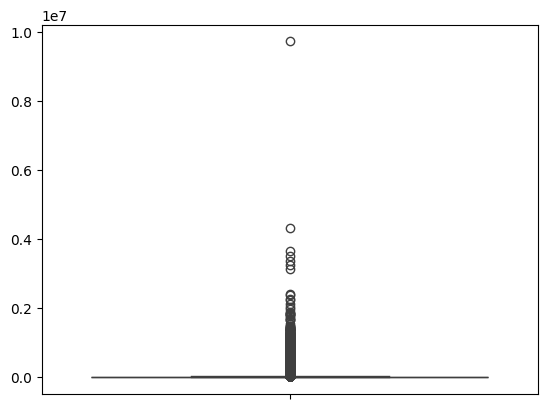

In [ ]:
import seaborn as sns

# boxplot помогает увидеть выбросы
sns.boxplot(week1['total_dur'].values)

In [ ]:
# кажется у нас есть выброс
week1['total_dur'].max()

9731801

In [ ]:
# кажется у нас есть выброс
week1[week1['total_dur'] == week1['total_dur'].max()]

,user_id,total_dur
128751,696597,9731801


In [ ]:
# удалим выбросы
print(week1.shape)
week1 = week1[(week1['total_dur'] < week1['total_dur'].std() * 3)]
print(week1.shape)

(185907, 2)
(183790, 2)


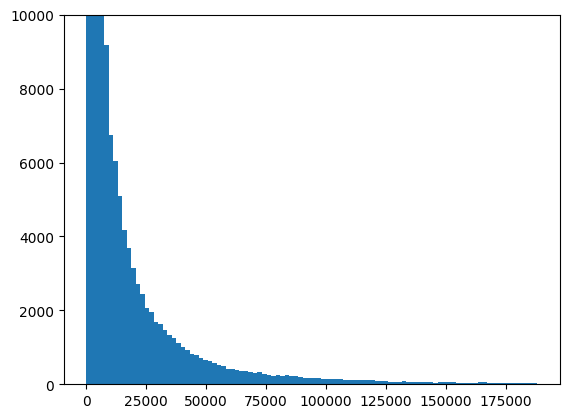

In [ ]:
week1['total_dur'].hist(bins=100)
plt.ylim([0, 10000])
plt.grid(False)

In [ ]:
def salt_generator():
  """Func for generating random salt if user does not set salt"""
  salt = os.urandom(8)
  return base64.b64encode(salt).decode('ascii')


def get_salt(user_salt=None, save_salt=True):
  """Func for setting salt"""

  # соль задает пользователь или генерируем
  if user_salt:
      salt = user_salt
  else:
      salt = salt_generator()

  # логируем соль
  if save_salt:
      today = datetime.today().date().strftime('%Y-%m-%d')
      with open(f"salt_{today}.txt", 'w') as f:
          f.write(salt)
  return salt


In [ ]:
# попробуйте запустить несколько раз и посмотрите на результат
# он каждый раз будет разный
salt_generator()

'bUB/9CrxRok='

In [ ]:
def get_hash(df, col='user_id', save_salt=True):

    # генерируем соль, если она не задана
    salt = salt_generator()

    # разбиваем id на 2 группы с использванием ф-ии хэширования mmh3 murmurhash
    dfh = df.copy()
    dfh['hash'] = dfh[col].apply(lambda x: mmh3.hash128(x + salt))
    dfh['group'] = dfh['hash'] % 2
    return dfh

In [ ]:
# делим пользователей на группы A и B по хэшу с использованием соли
# появится новый столбец group с номером группы (0 или 1)
week1 = get_hash(df=week1, col='user_id')
week1.head()

,user_id,total_dur,hash,group
0,1,1593,251699967220607876371096106948072582711,1
1,1000001,52,99522422713758221510280672351379526633,1
2,1000003,625,332532701497204049142049582118940914587,1
3,1000008,3691,334453498397504337813726171508596556716,0
4,1000009,2444,92747467696560190977568263794944100343,1


In [ ]:
from scipy.stats import mannwhitneyu

# проверим, как работает код критерия Манна-Уитни
u, p = mannwhitneyu(week1[week1['group'] == 0]['total_dur'].values,
                    week1[week1['group'] == 1]['total_dur'].values)

print(f"Значение статистики = {u}, p_value = {p}")

Значение статистики = 4223839967.0, p_value = 0.8950474665199681


In [ ]:
# массив, куда будем сохранять значения p_value
pvalues = []

for i in tqdm(range(100)):  # 1000 итераций в реальности

  # каждый раз ПЕРЕразбиваем на группы
  # иначе вы получите 1000 одинаковых результатов
  week1_hash = get_hash(week1, save_salt=False)

  u, p = mannwhitneyu(
        week1_hash[week1_hash['group'] == 0]['total_dur'].values, # Группа А
        week1_hash[week1_hash['group'] == 1]['total_dur'].values # Группа В
    )
  pvalues.append(p) # сохраняем p_value на каждой итерации

  0%|          | 0/100 [00:00<?, ?it/s]

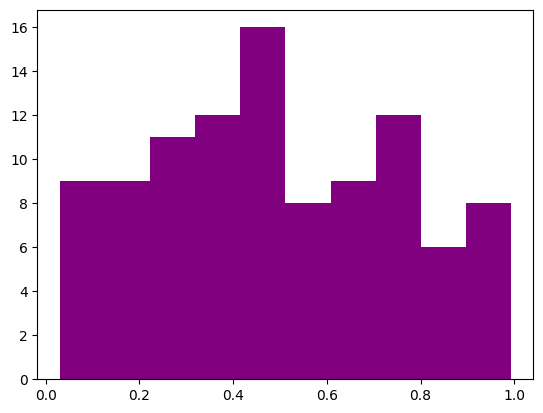

In [ ]:
# смотрим распределение получившихся после АА-теста значений p_value
plt.hist(pvalues, bins=10, color='purple');

In [ ]:
for i in tqdm(range(10)):

  week1_hash = get_hash(week1, save_salt=False)

  group_a = week1_hash[week1_hash['group'] == 0]
  group_b = week1_hash[week1_hash['group'] == 1]

  print(f"% уник. значений группы А = {round(group_a['total_dur'].nunique() / group_a.shape[0] * 100, 2)}%")
  print(f"% уник. значений группы B = {round(group_b['total_dur'].nunique() / group_b.shape[0] * 100, 2)}%")
  print('')


  0%|          | 0/10 [00:00<?, ?it/s]

% уник. значений группы А = 34.43%
% уник. значений группы B = 34.45%

% уник. значений группы А = 34.49%
% уник. значений группы B = 34.34%

% уник. значений группы А = 34.32%
% уник. значений группы B = 34.6%

% уник. значений группы А = 34.54%
% уник. значений группы B = 34.32%

% уник. значений группы А = 34.33%
% уник. значений группы B = 34.51%

% уник. значений группы А = 34.46%
% уник. значений группы B = 34.35%

% уник. значений группы А = 34.33%
% уник. значений группы B = 34.58%

% уник. значений группы А = 34.46%
% уник. значений группы B = 34.34%

% уник. значений группы А = 34.37%
% уник. значений группы B = 34.56%

% уник. значений группы А = 34.31%
% уник. значений группы B = 34.58%



In [ ]:
def bootstrap_mean_diff_ci(group_a, group_b, alpha=0.05,
                           iters=1000, return_distribution=False):
    values = []
    for _ in range(iters):
        values.append(
            # np.random.choice создает выборку с возвращением при replace=True
            # сразу считаем mean A - mean B
            np.random.choice(group_a, replace=True, size=len(group_a)).mean()
            -
            np.random.choice(group_b, replace=True, size=len(group_b)).mean()
        )

    if return_distribution:
         # возвращаем сами значения массива и квантили распределения
        return values, np.percentile(values, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    else:
        # возвращаем квантили распределения
        return np.percentile(values, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

In [ ]:
N = 100  # кол-во циклов для АА
significance_list = []
value_list = []

for i in tqdm(range(N)):  # кол-во циклов для АА

  week_hash = get_hash(week1, save_salt=False)

  group_a = week_hash[week_hash['group'] == 0]['total_dur'].values
  group_b = week_hash[week_hash['group'] == 1]['total_dur'].values

  values, (left_side, right_side) = bootstrap_mean_diff_ci(
      group_a,
      group_b,
      iters=1000,  # кол-во циклов сэмплирования для бутстреп критерия
      return_distribution=True
  )

  significance_list.append(not left_side <= 0 <= right_side)
  value_list.append(values)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# посчитаем значения p_value по определению p_value = P(TS | H_0 is true)
# передадим в get_p_value разницы средних от бутстрапа

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [ ]:
p_values = [get_p_value(values) for values in value_list]
p_values

[0.8260000000000001,
 0.09600000000000009,
 0.806,
 0.4,
 0.09200000000000008,
 0.256,
 0.4059999999999999,
 0.52,
 0.752,
 0.21599999999999997,
 0.6180000000000001,
 0.16199999999999992,
 0.8620000000000001,
 0.6100000000000001,
 0.3400000000000001,
 0.7,
 0.5720000000000001,
 0.882,
 0.038000000000000034,
 0.9359999999999999,
 0.618,
 0.030000000000000027,
 0.1459999999999999,
 0.538,
 0.052,
 0.024,
 0.9019999999999999,
 0.052000000000000046,
 0.75,
 0.36,
 0.818,
 0.32200000000000006,
 0.08000000000000007,
 0.854,
 0.536,
 0.3979999999999999,
 0.248,
 0.47,
 0.1259999999999999,
 0.466,
 0.8919999999999999,
 0.794,
 0.482,
 0.0040000000000000036,
 0.5640000000000001,
 0.336,
 0.066,
 0.33,
 0.718,
 0.978,
 0.954,
 0.252,
 0.252,
 0.978,
 0.22,
 0.692,
 0.542,
 0.804,
 0.20799999999999996,
 0.054,
 0.08800000000000008,
 0.28,
 0.706,
 0.924,
 0.87,
 0.8879999999999999,
 0.732,
 0.346,
 0.27,
 0.15999999999999992,
 0.386,
 0.9299999999999999,
 0.99,
 0.86,
 0.698,
 0.8480000000000001,

Text(0.5, 1.0, 'Бутстреп распределение p_value\nsignificance = 0.04')

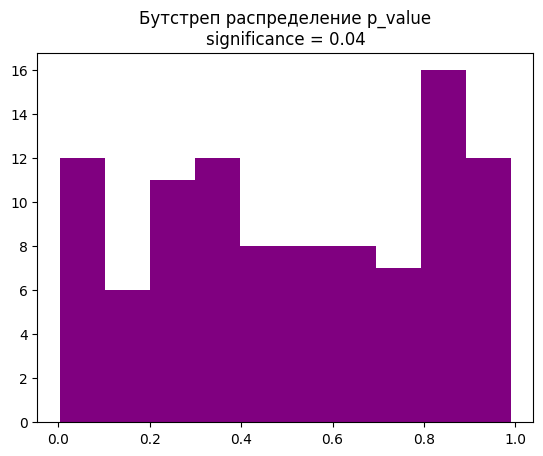

In [ ]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value\nsignificance = {np.round(np.mean(significance_list), 2)}")

In [ ]:
import scipy.stats

stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
  print(f'p_value = {p_value} -> p_values неравномерное распределение')
else:
  print(f'p_value = {p_value} -> p_values равномерное распределение')

p_value = 0.6171494172888625 -> p_values равномерное распределение


In [ ]:
N = 10  # кол-во итераций "псевдо-АВ" для мощности
power_list = []
effect_list = [0.01, 0.03, 0.05]  # [1%, 3%, 5%]

for effect in effect_list:

  power = []

  for i in tqdm(range(N)):

    week_hash = get_hash(week1, save_salt=False)

    group_a = week_hash[week_hash['group'] == 0]['total_dur'].values
    group_b = week_hash[week_hash['group'] == 1]['total_dur'].values


    left_side, right_side = bootstrap_mean_diff_ci(
      group_a,
      group_b * (1 + effect), # теперь добавляем эффект к группе В
      iters=10,  # iters = 1000 для реальных данных
      return_distribution=False
    )

    power.append(not left_side <= 0 <= right_side)

  power_list.append(power)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def plot_power(effect_list, power_list,
               color='pink', title='', verbose=True):

    """Function for plotting nice power plots"""

    x = effect_list
    y = [np.array(power_list[index]).mean() for index in range(len(effect_list))]

    if verbose:
        for effect, power in zip(x, y):
            print(f"вероятность, что бутстрап критерий найдет отличие в {effect * 100}% = "
                  f"{np.round(power, 2)}")

    fig, ax = plt.subplots(1,1)
    ax.plot(x, y, marker='o', color=color)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{effect}" for effect in effect_list])
    ax.grid(False)
    ax.set_ylim([0, 1.1])
    plt.title(title)


вероятность, что бутстрап критерий найдет отличие в 1.0% = 0.4
вероятность, что бутстрап критерий найдет отличие в 3.0% = 0.9
вероятность, что бутстрап критерий найдет отличие в 5.0% = 1.0


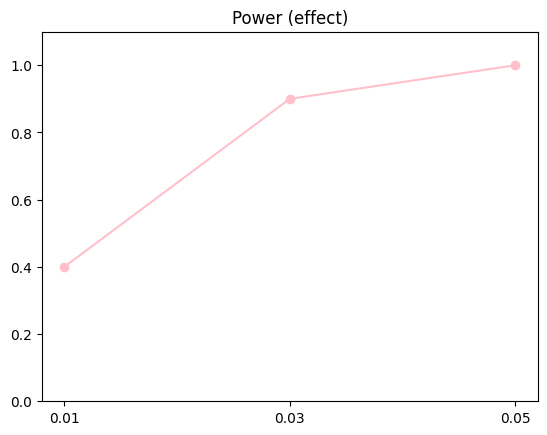

In [ ]:
plot_power(effect_list, power_list=power_list, title='Power (effect)')

# Homework

In [ ]:
#1 Получение данных для week2 и week3

max_date = interactions['last_watch_dt'].max()

# week2
week2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days = 14)]
week2 = week2.groupby('user_id', as_index = False).agg({'total_dur': sum})
week2 = week2[(week2['total_dur'] < week2['total_dur'].std() * 3)]

# week3
week3 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days = 21)]
week3 = week3.groupby('user_id', as_index = False).agg({'total_dur': sum})
week3 = week3[(week3['total_dur'] < week3['total_dur'].std() * 3)]

In [ ]:

#2 Фиксация эффекта

effect = 0.025

In [ ]:
#3 Расчет мощности для всех недель

def calculate_power(week_data, effect, N = 100, iters = 1000):
  power_list = []

# Разделяем группы на А и В
  for i in tqdm(range(N)):
    week_hash = get_hash(week_data, save_salt = False)

    group_a = week_hash[week_hash['group'] == 0]['total_dur'].values
    group_b = week_hash[week_hash['group'] == 1]['total_dur'].values

# Используем для оценки мощности бутстрап - метод. Добавим эффект к гркппе В

    left_side, right_side = bootstrap_mean_diff_ci(
        group_a,
        group_b * (1 + effect),
        iters = iters,
        return_distribution = False
    )

    power_list.append(not left_side <= 0 <= right_side)

  return power_list

power_week1 = calculate_power(week1, effect)
power_week2 = calculate_power(week2, effect)
power_week3 = calculate_power(week3, effect)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

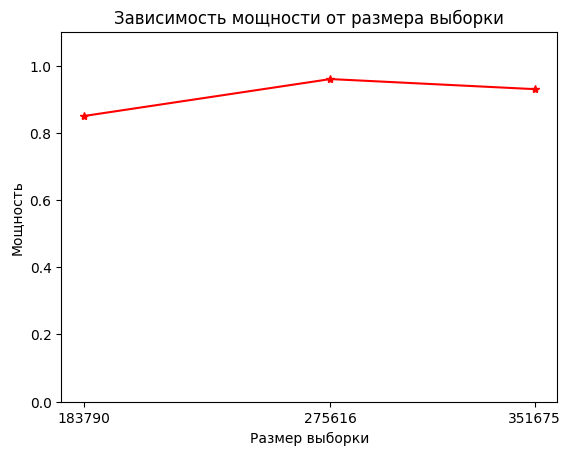

In [ ]:
#3 Построение графика зависимости мощности от размера выборки

# Получение размер выборок

sizes = [week1.shape[0], week2.shape[0], week3.shape[0]]

# Средняя значения мощностей
powers = [np.mean(power_week1), np.mean(power_week2), np.mean(power_week3)]

# Функция для построения графика

def plot_power(sizes, powers, color = 'red', title = 'Зависимость мощности от размера выборки'):
  fig, ax = plt.subplots(1, 1)
  ax.plot(sizes, powers, marker = '*', color = color)
  ax.set_xticks(sizes)
  ax.set_xticklabels([f"{size}" for size in sizes])
  ax.set_ylim([0, 1.1])
  ax.set_xlabel('Размер выборки')
  ax.set_ylabel('Мощность')
  ax.grid(False)
  plt.title(title)
  plt.show()

plot_power(sizes, powers, title = 'Зависимость мощности от размера выборки')

In [ ]:
#4 Выводы

for size, power in zip(sizes, powers):
  print(f"Размер выборки: {size}, Мощность: {power:.2f}")

# Выьор размера выборки

if powers[0] >= 0.8:
  chosen_size = sizes[0]
  duration = '1 week'
elif powers[1] >= 0.8:
  chosen_size = sizes[1]
  duration = '2 weeks'
else:
  chosen_size = sizes[2]
  duration = '3 weeks'

print(f"Для теста выбрана выборка размером {chosen_size}, что соответствует длительности {duration}.")


Размер выборки: 183790, Мощность: 0.85
Размер выборки: 275616, Мощность: 0.96
Размер выборки: 351675, Мощность: 0.93
Для теста выбрана выборка размером 183790, что соответствует длительности 1 week.


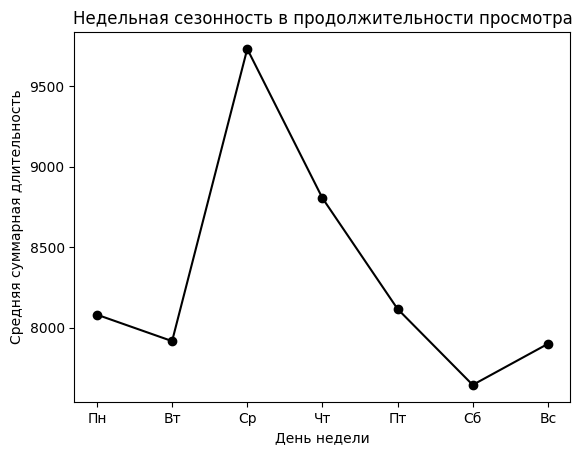

In [ ]:
#5 Бонус пункт Анализ сезонности

# Добавление столбцов с днемя неделями

interactions['day_of_week'] = interactions['last_watch_dt'].apply(lambda x: x.weekday())

# Группировка данных по дням и расчет средних значений duration

weekly_trend = interactions.groupby('day_of_week')['total_dur'].mean()

# Построение графика

plt.plot(weekly_trend.index, weekly_trend.values, marker = 'o', color = 'black')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.xlabel('День недели')
plt.ylabel('Средняя суммарная длительность')
plt.title('Недельная сезонность в продолжительности просмотра')
plt.grid(False)
plt.show()

# Results

**1)Для эффекта 1%**

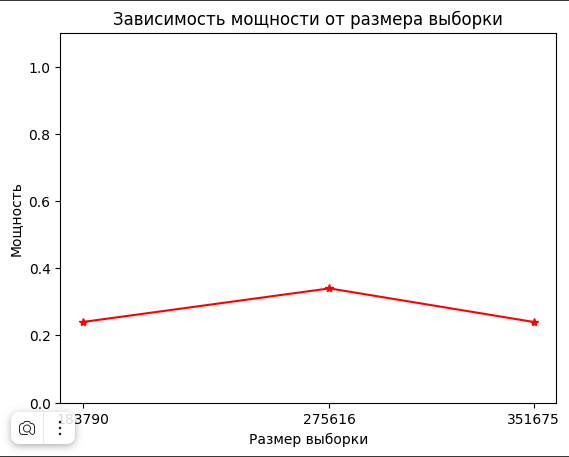

Размер выборки: 183790, Мощность: 0.24

Размер выборки: 275616, Мощность: 0.34

Размер выборки: 351675, Мощность: 0.24

Размеры выборок недостачны для такого малого эффекта нужно увеличить размер выборки

**2) Для эффекта 2%**

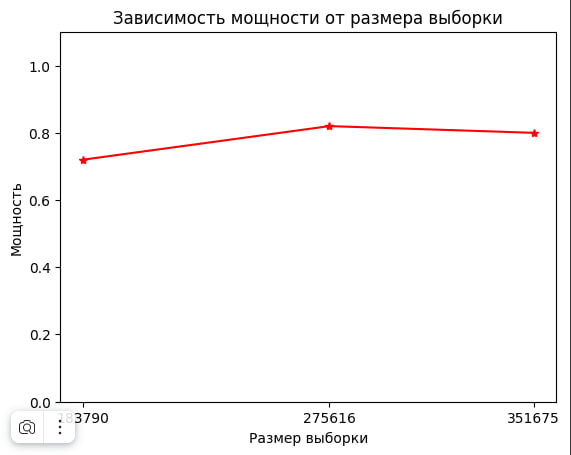

Размер выборки: 183790, Мощность: 0.72

Размер выборки: 275616, Мощность: 0.82

Размер выборки: 351675, Мощность: 0.80

Для теста выбрана выборка размером 275616, что соответствует длительности 2 weeks.

**3) Для эффекта 3%**

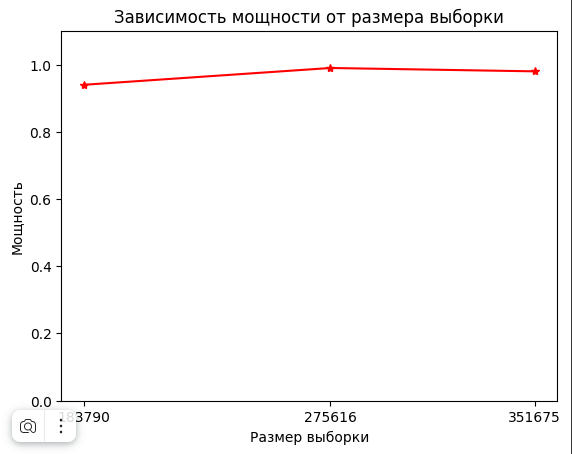

Размер выборки: 183790, Мощность: 0.94

Размер выборки: 275616, Мощность: 0.99

Размер выборки: 351675, Мощность: 0.98

Для теста выбрана выборка размером 183790, что соответствует длительности 1 week.

**4)Для эффекта 2.5%**

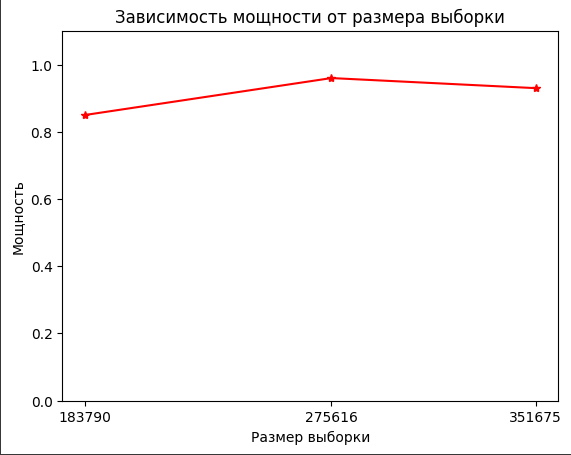

Размер выборки: 183790, Мощность: 0.85

Размер выборки: 275616, Мощность: 0.96

Размер выборки: 351675, Мощность: 0.93

Для теста выбрана выборка размером 183790, что соответствует длительности 1 week.


При этом максимальная активность пользователей наблюдается в среду, что следует учитывать при планировке теста